## Рыночная стоимость автомобиля

### 1. Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import lightgbm as lgb

In [2]:
from scipy import stats
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

In [3]:
cars = pd.read_csv('/datasets/autos.csv')
cars.head(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


In [4]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


In [5]:
cars.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Сразу бросается в глаза большое количество пропусков в 5 столбцах. Особенно в столбце "NotRepaired" (была машина в ремонте или нет).  
Также 3 столбца с датой имеют тип object: "DateCrawled", "DateCreated" и "LastSeen". Их мы приведем к формату даты и времени.  
Помимо этого изменим названия столбцов, чтобы было удобнее к ним обращаться.  
Начнем со смены названий:

In [6]:
cars.columns = ['date_crawled', 'price', 'vehicle_type', 'reg_year', 'gearbox', 'power', 'model', 
                'km', 'reg_month', 'fuel_type', 'brand', 'not_repaired', 'date_created', 
                'pictures', 'postal_code', 'last_seen']
cars.head(3)

,date_crawled,price,vehicle_type,reg_year,gearbox,power,model,km,reg_month,fuel_type,brand,not_repaired,date_created,pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46


Также внимание привлекли нулевые значения в первых десяти строках в столбце с количеством фотографий машин - "pictures". Проверим, есть ли какие-либо еще значения:

In [7]:
cars.pictures.unique()

array([0])

Никаких других значений в столбце нет. Удалим его, т.к. никакой значимости для последующего обучения моделей он не несет:

In [8]:
cars = cars.drop('pictures', axis=1)
cars.head(3)

,date_crawled,price,vehicle_type,reg_year,gearbox,power,model,km,reg_month,fuel_type,brand,not_repaired,date_created,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,90480,2016-04-05 12:47:46


Точно так же можно удалить и столбец с индексами клиентов, поскольку и он не несет никакой значимости при обучении модели. Если бы нашей целью было предсказать, в каком регионе чаще будут продаваться машины, тогда индексы были бы нужны. Сейчас нет. Удаляем:

In [9]:
cars = cars.drop('postal_code', axis=1)
cars.head(3)

,date_crawled,price,vehicle_type,reg_year,gearbox,power,model,km,reg_month,fuel_type,brand,not_repaired,date_created,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,2016-04-05 12:47:46


Переходим к присваиванию типов колонкам с датой и временем:

In [10]:
cars[['date_crawled', 'date_created', 'last_seen']] = cars[['date_crawled', 
                                                            'date_created', 'last_seen']].apply(pd.to_datetime)

In [11]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 14 columns):
date_crawled    354369 non-null datetime64[ns]
price           354369 non-null int64
vehicle_type    316879 non-null object
reg_year        354369 non-null int64
gearbox         334536 non-null object
power           354369 non-null int64
model           334664 non-null object
km              354369 non-null int64
reg_month       354369 non-null int64
fuel_type       321474 non-null object
brand           354369 non-null object
not_repaired    283215 non-null object
date_created    354369 non-null datetime64[ns]
last_seen       354369 non-null datetime64[ns]
dtypes: datetime64[ns](3), int64(5), object(6)
memory usage: 37.9+ MB


Проверим датафрейм на наличие дубликатов:

In [12]:
cars.duplicated().sum()

5

In [13]:
cars[cars.duplicated() == True]

,date_crawled,price,vehicle_type,reg_year,gearbox,power,model,km,reg_month,fuel_type,brand,not_repaired,date_created,last_seen
149164,2016-03-07 12:00:46,10000,wagon,2013,manual,184,golf,60000,7,gasoline,volkswagen,no,2016-03-07,2016-03-20 12:49:27
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08,2016-03-09 09:46:57
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28,2016-03-28 08:46:21
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03,2016-04-07 09:44:54
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18,2016-03-18 18:46:15


Удалим их:

In [14]:
cars = cars.drop_duplicates().reset_index(drop = True)
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354364 entries, 0 to 354363
Data columns (total 14 columns):
date_crawled    354364 non-null datetime64[ns]
price           354364 non-null int64
vehicle_type    316874 non-null object
reg_year        354364 non-null int64
gearbox         334531 non-null object
power           354364 non-null int64
model           334659 non-null object
km              354364 non-null int64
reg_month       354364 non-null int64
fuel_type       321469 non-null object
brand           354364 non-null object
not_repaired    283210 non-null object
date_created    354364 non-null datetime64[ns]
last_seen       354364 non-null datetime64[ns]
dtypes: datetime64[ns](3), int64(5), object(6)
memory usage: 37.9+ MB


Теперь посмотрим на пропуски. Посчитаем, сколько всего строк с пропусками:

In [15]:
cars.shape[0] - cars.dropna().shape[0]

108555

Теперь посмотрим, сколько пропусков и в каких столбцах они есть:

In [16]:
cars.isna().sum()

date_crawled        0
price               0
vehicle_type    37490
reg_year            0
gearbox         19833
power               0
model           19705
km                  0
reg_month           0
fuel_type       32895
brand               0
not_repaired    71154
date_created        0
last_seen           0
dtype: int64

Поскольку удалить такое количество данных мы не можем, посмотрим на каждый столбец с пропусками отдельно. Начнем с того, где их меньше всего - со столбца "fuel_type":

In [17]:
cars.fuel_type.unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

In [18]:
cars.loc[cars['fuel_type'].isnull()]

,date_crawled,price,vehicle_type,reg_year,gearbox,power,model,km,reg_month,fuel_type,brand,not_repaired,date_created,last_seen
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17,2016-03-31 17:17:06
13,2016-03-21 21:37:40,2500,wagon,2004,manual,131,passat,150000,2,NaN,volkswagen,no,2016-03-21,2016-03-23 02:50:54
26,2016-03-10 19:38:18,5555,NaN,2017,manual,125,c4,125000,4,NaN,citroen,no,2016-03-10,2016-03-16 09:16:46
36,2016-03-11 11:50:37,1600,other,1991,manual,75,kadett,70000,0,NaN,opel,NaN,2016-03-11,2016-04-07 03:46:09
41,2016-03-30 20:38:20,7500,sedan,2002,auto,306,e_klasse,150000,4,NaN,mercedes_benz,NaN,2016-03-30,2016-04-03 11:44:49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354334,2016-03-20 12:46:00,3850,convertible,2006,manual,108,2_reihe,125000,2,NaN,peugeot,no,2016-03-20,2016-03-26 21:18:23
354341,2016-03-07 17:06:35,2600,NaN,2005,auto,0,c_klasse,150000,9,NaN,mercedes_benz,NaN,2016-03-07,2016-03-08 21:28:38
354346,2016-03-11 23:40:32,1900,NaN,2000,manual,110,NaN,150000,7,NaN,volkswagen,no,2016-03-11,2016-03-12 14:16:51
354356,2016-03-09 13:37:43,5250,NaN,2016,auto,150,159,150000,12,NaN,alfa_romeo,no,2016-03-09,2016-03-13 01:44:13


Помимо пропусков в столбце "fuel_type" мы наблюдаем пропуски и в других столбцах. Т.к. в столбцах "vehicle_type" и "fuel_type" примерно одинаковое количество пропусков, посмотрим, сколько строк имеют пропуски в них одновременно:

In [19]:
cars.loc[cars['fuel_type'].isnull() & cars['vehicle_type'].isnull()]

,date_crawled,price,vehicle_type,reg_year,gearbox,power,model,km,reg_month,fuel_type,brand,not_repaired,date_created,last_seen
26,2016-03-10 19:38:18,5555,NaN,2017,manual,125,c4,125000,4,NaN,citroen,no,2016-03-10,2016-03-16 09:16:46
52,2016-04-04 10:57:36,1400,NaN,2016,manual,55,other,5000,1,NaN,hyundai,NaN,2016-04-04,2016-04-06 12:45:43
57,2016-03-10 20:53:19,2399,NaN,2018,manual,64,other,125000,3,NaN,seat,no,2016-03-10,2016-03-25 10:17:37
65,2016-03-28 17:41:27,10900,NaN,2017,manual,101,astra,50000,3,NaN,opel,no,2016-03-28,2016-04-06 23:15:52
71,2016-03-07 08:55:18,2300,NaN,1997,manual,150,5er,150000,3,NaN,bmw,no,2016-03-07,2016-03-22 05:15:22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354300,2016-04-03 13:46:24,3500,NaN,1995,NaN,0,polo,150000,0,NaN,volkswagen,NaN,2016-04-03,2016-04-05 12:44:38
354341,2016-03-07 17:06:35,2600,NaN,2005,auto,0,c_klasse,150000,9,NaN,mercedes_benz,NaN,2016-03-07,2016-03-08 21:28:38
354346,2016-03-11 23:40:32,1900,NaN,2000,manual,110,NaN,150000,7,NaN,volkswagen,no,2016-03-11,2016-03-12 14:16:51
354356,2016-03-09 13:37:43,5250,NaN,2016,auto,150,159,150000,12,NaN,alfa_romeo,no,2016-03-09,2016-03-13 01:44:13


Получается, у 17295 строк есть пропуски в 2 столбцах. А сколько строк имеют пропуски в каждом из 5 столбцов единовременно?

In [20]:
nan_rows_1 = cars.loc[cars['fuel_type'].isnull() & cars['vehicle_type'].isnull() 
         & cars['gearbox'].isnull() & cars['model'].isnull() & cars['not_repaired'].isnull()]
len(nan_rows_1)

2237

In [21]:
index = nan_rows_1.index.to_list()
index[:5]

[306, 522, 538, 552, 622]

От этих строк избавимся, т.к. правильно восстановить данные в них не представляется возможным:

In [22]:
cars = cars.drop(cars.index[[i for i in cars.index if i in index]])
cars.shape[0]

352127

In [23]:
cars.shape[0] - cars.dropna().shape[0] 

106318

Удалим ненужные переменные: 'nan_rows_1' и 'index':

In [24]:
del nan_rows_1
del index

Теперь посмотрим на строки, в которых пропуски есть одновременно в четырех столбцах (кроме "not_repaired"):

In [25]:
nan_rows_2 = cars.loc[cars['fuel_type'].isnull() & cars['vehicle_type'].isnull() 
         & cars['gearbox'].isnull() & cars['model'].isnull()]
nan_rows_2.head()

,date_crawled,price,vehicle_type,reg_year,gearbox,power,model,km,reg_month,fuel_type,brand,not_repaired,date_created,last_seen
4867,2016-04-03 19:52:01,0,NaN,2000,NaN,0,NaN,150000,0,NaN,volkswagen,no,2016-04-03,2016-04-05 20:45:15
6580,2016-04-04 12:49:34,0,NaN,2018,NaN,0,NaN,5000,0,NaN,sonstige_autos,no,2016-04-04,2016-04-06 14:16:07
11196,2016-04-05 18:36:22,300,NaN,1995,NaN,0,NaN,150000,9,NaN,audi,yes,2016-04-05,2016-04-05 18:36:22
11788,2016-03-08 12:51:52,350,NaN,2017,NaN,75,NaN,150000,0,NaN,volkswagen,yes,2016-03-08,2016-03-12 05:46:53
23331,2016-03-08 21:51:55,500,NaN,2000,NaN,0,NaN,100000,0,NaN,sonstige_autos,no,2016-03-08,2016-03-13 03:46:59


Удалим и их.

In [26]:
cars = cars.drop(nan_rows_2.index, axis = 0)
cars

,date_crawled,price,vehicle_type,reg_year,gearbox,power,model,km,reg_month,fuel_type,brand,not_repaired,date_created,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354358,2016-03-27 20:36:20,1150,bus,2000,manual,0,zafira,150000,3,petrol,opel,no,2016-03-27,2016-03-29 10:17:23
354359,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21,2016-03-21 10:42:49
354361,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05,2016-03-11 18:17:12
354362,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19,2016-04-07 07:15:26


И дополнительно обновим индексы:

In [27]:
cars = cars.reset_index(drop=True)
cars

,date_crawled,price,vehicle_type,reg_year,gearbox,power,model,km,reg_month,fuel_type,brand,not_repaired,date_created,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
351967,2016-03-27 20:36:20,1150,bus,2000,manual,0,zafira,150000,3,petrol,opel,no,2016-03-27,2016-03-29 10:17:23
351968,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21,2016-03-21 10:42:49
351969,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05,2016-03-11 18:17:12
351970,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19,2016-04-07 07:15:26


In [28]:
del nan_rows_2

Теперь попробуем дозаполнить значения. Вызовем информацию о пропусках в датафрейме:

In [29]:
cars.isna().sum()

date_crawled        0
price               0
vehicle_type    35098
reg_year            0
gearbox         17441
power               0
model           17313
km                  0
reg_month           0
fuel_type       30503
brand               0
not_repaired    68917
date_created        0
last_seen           0
dtype: int64

Удалили немного. 
Переходим к заполнению столбца с моделями автомобилей, т.к. заполнив этот столбец, остальные заполнить будет проще. Заполним столбец модой на основе группировки по бренду.

In [30]:
c = cars.groupby('brand')['model'].apply(lambda x: x.mode())
c = c.reset_index()
c = c.drop('level_1', axis=1)
c

,brand,model
0,alfa_romeo,156
1,audi,a4
2,bmw,3er
3,chevrolet,other
4,chrysler,other
5,citroen,other
6,dacia,logan
7,daewoo,matiz
8,daihatsu,cuore
9,fiat,punto


Проверим, все ли бренды имеют модели или есть исключения:

In [31]:
len(cars.brand.unique())

40

Итого: 39 моделей в таблице ___"с"___ и 40 - в ___"cars"___. Для одного бренда модели не указаны. Найдем его:

In [32]:
print(list(set(cars.brand.unique()) - set(c.brand)))

['sonstige_autos']


У этого бренда в датафрейме "cars" нет ни одной модели. Сколько таких значений?

In [33]:
cars[cars['brand'] == 'sonstige_autos']

,date_crawled,price,vehicle_type,reg_year,gearbox,power,model,km,reg_month,fuel_type,brand,not_repaired,date_created,last_seen
59,2016-03-29 15:48:15,1,suv,1994,manual,286,NaN,150000,11,NaN,sonstige_autos,NaN,2016-03-29,2016-04-06 01:44:38
430,2016-03-20 20:45:27,3950,small,2004,auto,5,NaN,70000,5,gasoline,sonstige_autos,no,2016-03-20,2016-04-03 04:17:08
645,2016-03-30 11:55:46,15000,coupe,1971,NaN,0,NaN,5000,4,NaN,sonstige_autos,no,2016-03-30,2016-04-07 02:45:10
656,2016-04-01 15:56:27,9900,suv,2000,auto,250,NaN,150000,4,lpg,sonstige_autos,no,2016-04-01,2016-04-07 14:56:03
695,2016-03-30 21:37:21,6999,sedan,2010,auto,186,NaN,125000,4,petrol,sonstige_autos,no,2016-03-30,2016-04-05 11:18:33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
351474,2016-03-29 00:38:48,5000,sedan,2006,manual,175,NaN,125000,12,petrol,sonstige_autos,no,2016-03-28,2016-04-05 14:16:37
351499,2016-03-06 11:42:12,7900,bus,2009,NaN,140,NaN,125000,7,gasoline,sonstige_autos,no,2016-03-06,2016-03-26 16:16:02
351568,2016-03-17 13:54:22,200,NaN,1910,NaN,0,NaN,5000,0,petrol,sonstige_autos,NaN,2016-03-17,2016-03-31 22:46:47
351669,2016-03-19 11:25:16,6000,small,2008,manual,155,NaN,150000,5,petrol,sonstige_autos,no,2016-03-19,2016-04-07 00:46:42


2623 строки. Удалим и их, поскольку дозаполнить их также проблематично.

In [34]:
cars = cars[cars['brand'] != 'sonstige_autos']
cars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 349349 entries, 0 to 351971
Data columns (total 14 columns):
date_crawled    349349 non-null datetime64[ns]
price           349349 non-null int64
vehicle_type    314541 non-null object
reg_year        349349 non-null int64
gearbox         332260 non-null object
power           349349 non-null int64
model           334659 non-null object
km              349349 non-null int64
reg_month       349349 non-null int64
fuel_type       319199 non-null object
brand           349349 non-null object
not_repaired    281058 non-null object
date_created    349349 non-null datetime64[ns]
last_seen       349349 non-null datetime64[ns]
dtypes: datetime64[ns](3), int64(5), object(6)
memory usage: 40.0+ MB


Теперь заполним пропуски в столбце "model":

In [35]:
cars['model_new'] = cars.groupby('brand')['model'].transform( lambda x: x.fillna(x.mode()[0]))
cars[150:160]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,date_crawled,price,vehicle_type,reg_year,gearbox,power,model,km,reg_month,fuel_type,brand,not_repaired,date_created,last_seen,model_new
151,2016-03-27 20:47:22,6799,small,2009,NaN,60,NaN,20000,5,petrol,volkswagen,no,2016-03-27,2016-03-27 20:47:22,golf
152,2016-03-11 18:55:53,0,bus,2004,manual,101,meriva,150000,10,lpg,opel,yes,2016-03-11,2016-03-12 23:47:10,meriva
153,2016-04-03 18:58:25,9450,convertible,2004,manual,170,z_reihe,150000,12,petrol,bmw,no,2016-04-03,2016-04-07 11:15:22,z_reihe
154,2016-03-22 16:37:59,0,NaN,2006,NaN,0,other,5000,0,NaN,fiat,NaN,2016-03-22,2016-04-06 06:17:56,other
155,2016-03-09 12:53:53,14500,NaN,2017,manual,136,sportage,125000,5,gasoline,kia,no,2016-03-09,2016-04-05 23:45:15,sportage
156,2016-03-10 16:57:31,6890,sedan,2003,manual,170,c_klasse,125000,2,gasoline,mercedes_benz,no,2016-03-10,2016-04-01 20:47:57,c_klasse
157,2016-03-23 14:45:57,7500,suv,2007,auto,194,sorento,5000,11,petrol,kia,NaN,2016-03-23,2016-04-05 15:47:51,sorento
158,2016-04-01 16:06:24,800,sedan,1993,manual,0,golf,10000,9,petrol,volkswagen,yes,2016-04-01,2016-04-07 11:17:07,golf
159,2016-03-08 19:58:07,1499,small,2002,manual,140,a_klasse,150000,10,NaN,mercedes_benz,no,2016-03-08,2016-03-10 17:44:36,a_klasse
160,2016-03-19 19:49:15,500,small,1999,manual,0,NaN,150000,0,petrol,renault,no,2016-03-19,2016-04-01 11:17:48,twingo


Столбец заполнили верно. Теперь можно удалить ненужные переменные и столбец "model":

In [36]:
cars = cars.drop('model', axis=1)
cars.head()

,date_crawled,price,vehicle_type,reg_year,gearbox,power,km,reg_month,fuel_type,brand,not_repaired,date_created,last_seen,model_new
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,150000,0,petrol,volkswagen,NaN,2016-03-24,2016-04-07 03:16:57,golf
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,125000,5,gasoline,audi,yes,2016-03-24,2016-04-07 01:46:50,a4
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,125000,8,gasoline,jeep,NaN,2016-03-14,2016-04-05 12:47:46,grand
3,2016-03-17 16:54:04,1500,small,2001,manual,75,150000,6,petrol,volkswagen,no,2016-03-17,2016-03-17 17:40:17,golf
4,2016-03-31 17:25:20,3600,small,2008,manual,69,90000,7,gasoline,skoda,no,2016-03-31,2016-04-06 10:17:21,fabia


In [37]:
del c

Далее для заполнения других пропусков можно использовать группирование по бренду и модели. Чтобы оперативнее заполнить пропуски, напишем функцию, принимающую на вход столбец, в котором нужно заполнить пропуски:

In [38]:
def fill_the_gaps(value):
    return cars.groupby(['brand', 'model_new'])[value].transform( lambda x: x.fillna(x.mode()[0]))

In [39]:
cars['box'] = fill_the_gaps('gearbox')
cars['vehicle'] = fill_the_gaps('vehicle_type')
cars['fuel'] = fill_the_gaps('fuel_type')

Удалим теперь ненужные столбцы:

In [40]:
cars = cars.drop(['gearbox', 'vehicle_type', 'fuel_type'], axis=1)

In [41]:
cars.isna().sum()

date_crawled        0
price               0
reg_year            0
power               0
km                  0
reg_month           0
brand               0
not_repaired    68291
date_created        0
last_seen           0
model_new           0
box                 0
vehicle             0
fuel                0
dtype: int64

In [42]:
cars.head(15)

,date_crawled,price,reg_year,power,km,reg_month,brand,not_repaired,date_created,last_seen,model_new,box,vehicle,fuel
0,2016-03-24 11:52:17,480,1993,0,150000,0,volkswagen,NaN,2016-03-24,2016-04-07 03:16:57,golf,manual,sedan,petrol
1,2016-03-24 10:58:45,18300,2011,190,125000,5,audi,yes,2016-03-24,2016-04-07 01:46:50,a4,manual,coupe,gasoline
2,2016-03-14 12:52:21,9800,2004,163,125000,8,jeep,NaN,2016-03-14,2016-04-05 12:47:46,grand,auto,suv,gasoline
3,2016-03-17 16:54:04,1500,2001,75,150000,6,volkswagen,no,2016-03-17,2016-03-17 17:40:17,golf,manual,small,petrol
4,2016-03-31 17:25:20,3600,2008,69,90000,7,skoda,no,2016-03-31,2016-04-06 10:17:21,fabia,manual,small,gasoline
5,2016-04-04 17:36:23,650,1995,102,150000,10,bmw,yes,2016-04-04,2016-04-06 19:17:07,3er,manual,sedan,petrol
6,2016-04-01 20:48:51,2200,2004,109,150000,8,peugeot,no,2016-04-01,2016-04-05 18:18:39,2_reihe,manual,convertible,petrol
7,2016-03-21 18:54:38,0,1980,50,40000,7,volkswagen,no,2016-03-21,2016-03-25 16:47:58,other,manual,sedan,petrol
8,2016-04-04 23:42:13,14500,2014,125,30000,8,ford,NaN,2016-04-04,2016-04-04 23:42:13,c_max,manual,bus,petrol
9,2016-03-17 10:53:50,999,1998,101,150000,0,volkswagen,NaN,2016-03-17,2016-03-31 17:17:06,golf,manual,small,petrol


Последний столбец с пропусками - "no_repaired" - заполним после правки столбцов с годом регистрации машин и километража, поскольку они будут иметь значение при заполнении столбца "no_repaired" (была ли машина в ремонте). Начнем с года:

Выведем все уникальные значения:

In [43]:
cars.reg_year.unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 1980, 2014, 1998, 2005, 1910,
       2016, 2007, 2009, 2002, 2018, 1997, 1990, 2017, 1981, 2003, 1994,
       1991, 1984, 2006, 1999, 2012, 2010, 2000, 1992, 2013, 1996, 1985,
       1989, 2015, 1982, 1976, 1983, 1973, 1969, 1971, 1987, 1986, 1988,
       1965, 1970, 1945, 1974, 1955, 1978, 1979, 1972, 1968, 1977, 1961,
       1960, 1966, 1975, 1963, 5000, 1954, 1967, 1956, 1000, 9999, 1500,
       2200, 1964, 3000, 2066, 1949, 1940, 1962, 2019, 1937, 1951, 1959,
       1953, 1958, 8000, 9000, 2900, 5900, 5911, 1933, 1400, 1950, 4000,
       1952, 1200, 8500, 1932, 3700, 1942, 1935, 1234, 1936, 6500, 1957,
       1923, 2290, 1930, 1001, 7000, 1929, 2500, 1943, 1934, 1938, 6000,
       1928, 1941, 1800, 1919, 5555, 1039, 1300, 2800, 1931, 4500, 1602,
       1111, 7800, 1947, 1927, 7100, 8200, 7500, 1600])

Как оказалось, столбец "reg_year" также требует правки: в нем есть несколько странных значений. Построим график распределения значений по столбцу:

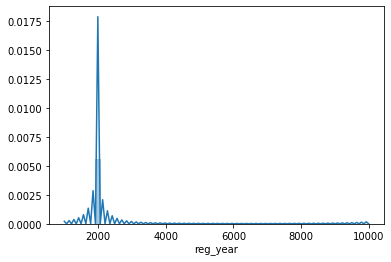

In [44]:
sns.distplot(cars.reg_year)

Посчитаем, сколько значений больше текущего, 2020, года:

In [45]:
len(cars.query('reg_year > 2020'))

68

Также посмотрим, сколько значений находятся ранее 1920 года (несмотря на то, что первое авто создано в 1885 году):

In [46]:
len(cars.query('reg_year < 1920'))

86

Удалим эти строки:

In [47]:
cars = cars.query('1920 < reg_year <= 2020')
cars.shape[0]

349195

Снова построим график:

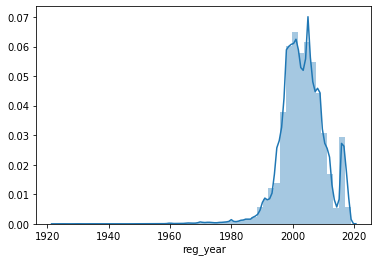

In [48]:
sns.distplot(cars.reg_year)

Чтобы приблизить столбец к нормальному распределению, посмотрим на выбросы:

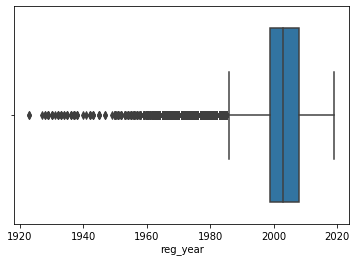

In [49]:
sns.boxplot(x=cars.reg_year)

In [50]:
cars.reg_year.describe()

count    349195.000000
mean       2003.197426
std           7.171284
min        1923.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        2019.000000
Name: reg_year, dtype: float64

Выбросов довольно много. Посчитаем, сколько их до 1986 года:

In [51]:
len(cars.query('reg_year < 1986'))

5121

Удалим их:

In [52]:
cars = cars.query('reg_year >= 1986')

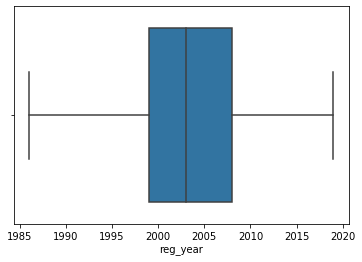

In [53]:
sns.boxplot(x=cars.reg_year)

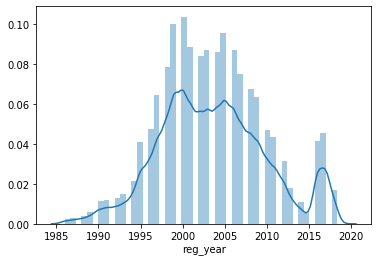

In [54]:
sns.distplot(cars.reg_year)

Наше распределение имеет выброс в районе 2016 - 2017 года. Оставим его как есть.

Столбец "km":

In [55]:
cars.km.unique()

array([150000, 125000,  90000,  30000,  70000, 100000,  60000,  20000,
        80000,   5000,  50000,  40000,  10000])

Тут всё в пределах нормы.

Теперь мы можем заполнить пропуски столбца "not_repaired":

In [56]:
cars['no_repaired'] = cars.groupby(['reg_year', 'km', 'brand'])['not_repaired'].transform \
                                ( lambda x: x.fillna((x.mode()[0] if not x.mode().empty else "Empty")))

In [57]:
cars.head(15)

,date_crawled,price,reg_year,power,km,reg_month,brand,not_repaired,date_created,last_seen,model_new,box,vehicle,fuel,no_repaired
0,2016-03-24 11:52:17,480,1993,0,150000,0,volkswagen,NaN,2016-03-24,2016-04-07 03:16:57,golf,manual,sedan,petrol,no
1,2016-03-24 10:58:45,18300,2011,190,125000,5,audi,yes,2016-03-24,2016-04-07 01:46:50,a4,manual,coupe,gasoline,yes
2,2016-03-14 12:52:21,9800,2004,163,125000,8,jeep,NaN,2016-03-14,2016-04-05 12:47:46,grand,auto,suv,gasoline,no
3,2016-03-17 16:54:04,1500,2001,75,150000,6,volkswagen,no,2016-03-17,2016-03-17 17:40:17,golf,manual,small,petrol,no
4,2016-03-31 17:25:20,3600,2008,69,90000,7,skoda,no,2016-03-31,2016-04-06 10:17:21,fabia,manual,small,gasoline,no
5,2016-04-04 17:36:23,650,1995,102,150000,10,bmw,yes,2016-04-04,2016-04-06 19:17:07,3er,manual,sedan,petrol,yes
6,2016-04-01 20:48:51,2200,2004,109,150000,8,peugeot,no,2016-04-01,2016-04-05 18:18:39,2_reihe,manual,convertible,petrol,no
8,2016-04-04 23:42:13,14500,2014,125,30000,8,ford,NaN,2016-04-04,2016-04-04 23:42:13,c_max,manual,bus,petrol,no
9,2016-03-17 10:53:50,999,1998,101,150000,0,volkswagen,NaN,2016-03-17,2016-03-31 17:17:06,golf,manual,small,petrol,no
10,2016-03-26 19:54:18,2000,2004,105,150000,12,mazda,no,2016-03-26,2016-04-06 10:45:34,3_reihe,manual,sedan,petrol,no


Проверим, сколько пустых значений в новом столбце:

In [58]:
len(cars[cars['no_repaired'] == 'Empty'])

771

Поменяем значения "Empty" на другие: используем так же моду и столбец бренд:

In [59]:
cars.loc[cars['no_repaired'] == 'Empty', 'no_repaired'] = cars.groupby('brand')['not_repaired'].transform \
                                                  (lambda x: x.mode()[0])

Проверяем:

In [60]:
len(cars[cars['no_repaired'] == 'Empty'])

0

In [61]:
cars['no_repaired'].unique()

array(['no', 'yes'], dtype=object)

И еще раз перепроверим точность заполнения. Отсортируем новый столбец "no_repaired" по значению "yes". Далее "вытащим" только те строки, где в "старом" столбце "not_repaired" есть пропуски:

In [62]:
repair = cars[cars['no_repaired'] == 'yes']
repair[repair['not_repaired'].isna()]

,date_crawled,price,reg_year,power,km,reg_month,brand,not_repaired,date_created,last_seen,model_new,box,vehicle,fuel,no_repaired
154,2016-03-22 16:37:59,0,2006,0,5000,0,fiat,NaN,2016-03-22,2016-04-06 06:17:56,other,manual,small,petrol,yes
157,2016-03-23 14:45:57,7500,2007,194,5000,11,kia,NaN,2016-03-23,2016-04-05 15:47:51,sorento,auto,suv,petrol,yes
1661,2016-03-30 23:57:49,0,2000,0,5000,0,ford,NaN,2016-03-30,2016-03-31 07:45:24,fiesta,manual,small,petrol,yes
1683,2016-03-08 21:53:29,500,2000,0,5000,0,volvo,NaN,2016-03-08,2016-03-09 13:47:10,v70,manual,wagon,gasoline,yes
2187,2016-03-16 14:54:11,1,2006,0,5000,0,jaguar,NaN,2016-03-16,2016-03-20 14:18:25,other,auto,sedan,petrol,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347096,2016-03-19 09:42:49,100,2000,0,5000,0,mitsubishi,NaN,2016-03-19,2016-04-06 07:17:49,colt,manual,sedan,petrol,yes
347165,2016-03-08 15:55:47,300,1999,45,150000,0,lancia,NaN,2016-03-08,2016-03-11 11:15:52,ypsilon,manual,small,petrol,yes
347269,2016-03-30 00:38:40,750,1998,50,5000,11,renault,NaN,2016-03-29,2016-03-30 06:42:33,twingo,manual,small,petrol,yes
347327,2016-03-28 15:59:52,0,1995,0,5000,0,renault,NaN,2016-03-28,2016-04-02 20:19:23,twingo,manual,small,petrol,yes


Теперь видно, что пропуски заполнены также и значениями "yes". Удалим столбец "not_repaired" и ненужные переменные:

In [63]:
cars = cars.drop('not_repaired', axis=1)
del repair

In [64]:
cars.shape[1]

14

Столбцов снова 14. Идем дальше:

Перепроверим столбцы с датой и временем (скорее всего, с ними всё нормально, т.к. иначе мы бы не смогли их перевести в формат даты и времени).  
Столбец "date_crawled":

In [65]:
print(cars.date_crawled.min())
print(cars.date_crawled.max())

2016-03-05 14:06:22
2016-04-07 14:36:58


In [66]:
print(cars.date_created.min())
print(cars.date_created.max())

2014-03-10 00:00:00
2016-04-07 00:00:00


In [67]:
print(cars.last_seen.min())
print(cars.last_seen.max())

2016-03-05 14:15:08
2016-04-07 14:58:51


Столбцы с датой и временем корректны.

Столбец "power":

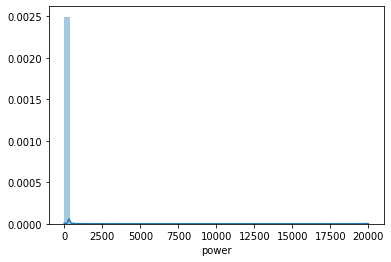

In [68]:
sns.distplot(cars.power)

20000 л.с. На такой машине можно лететь в космос. А сколько нулевых значений?

In [69]:
len(cars[cars['power'] == 0])

35981

Построим боксплот и более предметро посмотрим на выбросы:

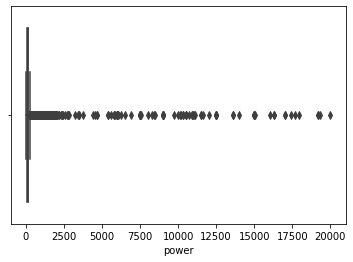

In [70]:
sns.boxplot(x=cars.power)

Посмотрим, сколько значений колеблется в интервале от 100 до 1500 л.с.:

In [71]:
ls = cars.query('100 < power < 1500')
ls

,date_crawled,price,reg_year,power,km,reg_month,brand,date_created,last_seen,model_new,box,vehicle,fuel,no_repaired
1,2016-03-24 10:58:45,18300,2011,190,125000,5,audi,2016-03-24,2016-04-07 01:46:50,a4,manual,coupe,gasoline,yes
2,2016-03-14 12:52:21,9800,2004,163,125000,8,jeep,2016-03-14,2016-04-05 12:47:46,grand,auto,suv,gasoline,no
5,2016-04-04 17:36:23,650,1995,102,150000,10,bmw,2016-04-04,2016-04-06 19:17:07,3er,manual,sedan,petrol,yes
6,2016-04-01 20:48:51,2200,2004,109,150000,8,peugeot,2016-04-01,2016-04-05 18:18:39,2_reihe,manual,convertible,petrol,no
8,2016-04-04 23:42:13,14500,2014,125,30000,8,ford,2016-04-04,2016-04-04 23:42:13,c_max,manual,bus,petrol,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
351963,2016-03-28 13:48:07,7900,2010,140,150000,7,volkswagen,2016-03-28,2016-04-02 18:16:20,golf,manual,sedan,gasoline,no
351965,2016-03-09 13:37:43,5250,2016,150,150000,12,alfa_romeo,2016-03-09,2016-03-13 01:44:13,159,auto,wagon,gasoline,no
351966,2016-03-19 19:53:49,3200,2004,225,150000,5,seat,2016-03-19,2016-03-19 20:44:43,leon,manual,sedan,petrol,yes
351969,2016-03-05 19:56:21,1199,2000,101,125000,3,smart,2016-03-05,2016-03-11 18:17:12,fortwo,auto,convertible,petrol,no


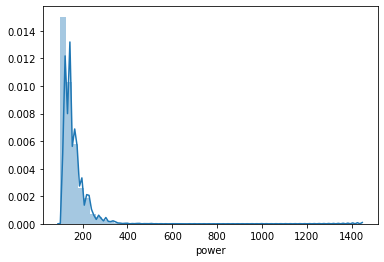

In [72]:
sns.distplot(ls.power)

Сколько строк имеют значение выше 400?

In [73]:
len(ls.query('power > 400'))

498

In [74]:
len(cars.query('power > 400'))

696

Таким образом, можно удалить значения свыше 400:

In [75]:
cars = cars[cars['power'] <= 400]

In [76]:
del ls

Построим боксплот для показателей до 400:

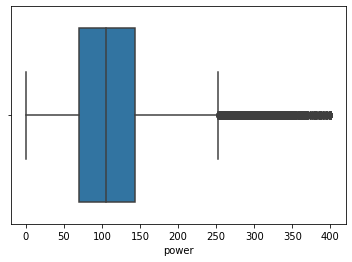

In [77]:
sns.boxplot(x=cars['power'])

Теперь посмотрим на выбросы, находящиеся у нуля:

In [78]:
cars.power.describe()

count    343378.000000
mean        107.280688
std          61.408082
min           0.000000
25%          70.000000
50%         105.000000
75%         143.000000
max         400.000000
Name: power, dtype: float64

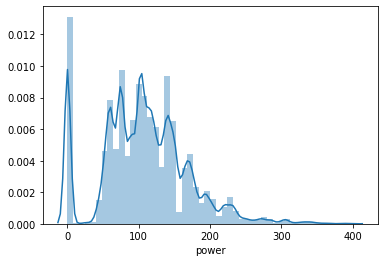

In [79]:
sns.distplot(cars.power)

In [80]:
len(cars[cars['power'] == 0])

35981

А что насчет значений менее 50 л.с.?

In [81]:
len(cars[cars['power'] < 50])

40944

Такое количество удалить нельзя, однако значения всё равно выглядят не очень правдоподобно. Заменим все значения менее 50, используя данные о модели и бренде:

In [82]:
cars.loc[cars['power'] < 50, 'power'] = cars.groupby(['reg_year', 'brand', 'model_new'])['power'].transform \
                                                  (lambda x: x.mode()[0])

Заменились не все, поскольку часть значений в выбранных подгруппах пустые. Посмотрим, сколько не заменилось:

In [83]:
cars_till_50 = cars[cars['power'] < 50]
len(cars_till_50)

10881

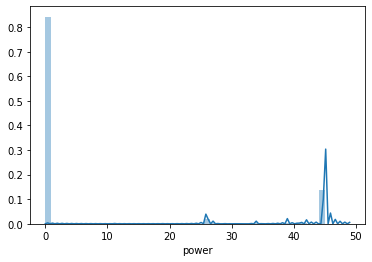

In [84]:
sns.distplot(cars_till_50['power'])

Какие бренды остались нулевыми?

In [85]:
cars_pow_0 = cars_till_50.query('power == 0') 
cars_pow_0.brand.unique()

array(['renault', 'opel', 'mitsubishi', 'volkswagen', 'mercedes_benz',
       'fiat', 'chevrolet', 'peugeot', 'ford', 'bmw', 'nissan', 'audi',
       'citroen', 'suzuki', 'porsche', 'mini', 'toyota', 'mazda', 'smart',
       'seat', 'chrysler', 'rover', 'lada', 'trabant', 'hyundai', 'jeep',
       'honda', 'volvo', 'daihatsu', 'daewoo', 'skoda', 'subaru',
       'alfa_romeo', 'lancia', 'jaguar', 'dacia', 'kia', 'saab',
       'land_rover'], dtype=object)

Возьмем среднее по брэндам в общей таблице и заменим ими:

In [86]:
cars.loc[cars['power'] == 0, 'power'] = cars.groupby(['brand'])['power'].transform(lambda x: x.mean())

In [87]:
cars.query('power == 0') 

,date_crawled,price,reg_year,power,km,reg_month,brand,date_created,last_seen,model_new,box,vehicle,fuel,no_repaired


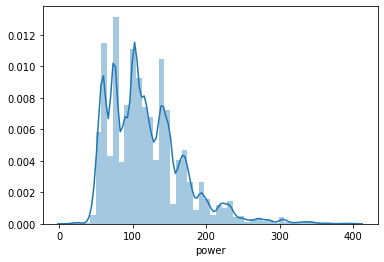

In [88]:
sns.distplot(cars['power'])

In [89]:
cars_till_50.query('power < 30')['brand'].unique()

array(['renault', 'opel', 'mitsubishi', 'volkswagen', 'mercedes_benz',
       'fiat', 'chevrolet', 'peugeot', 'ford', 'bmw', 'nissan', 'audi',
       'citroen', 'suzuki', 'porsche', 'mini', 'toyota', 'mazda', 'smart',
       'seat', 'chrysler', 'rover', 'lada', 'trabant', 'hyundai', 'jeep',
       'honda', 'volvo', 'daihatsu', 'daewoo', 'skoda', 'subaru',
       'alfa_romeo', 'lancia', 'jaguar', 'dacia', 'kia', 'saab',
       'land_rover'], dtype=object)

In [90]:
cars.shape

(343378, 14)

Согласно информации, полученной с просторов интернета, единственный бренд, точно имеющий мощность до 30 л.с. (26 л.с.) - это Трабант. Править не будем, т.к. этот автомобиль действительно обладает такой мощностью. Остальные 54 строки удалим:

In [91]:
cars = cars.query('power >= 30 or brand == "trabant"')
cars.shape

(343324, 14)

In [92]:
del cars_till_50
del cars_pow_0

И последний столбец, нуждающийся в правке, - месяц регистрации автомобиля ("reg_month"):

In [93]:
cars.reg_month.value_counts()

0     33655
3     33569
6     30752
4     28603
5     28494
7     26258
10    25686
12    23865
11    23812
9     23322
1     22348
8     22171
2     20789
Name: reg_month, dtype: int64

Много нулевых значений. Будем точно так же заменять их модой, используя для этого столбцы с годом, брэндом автомобиля и датой создания анкеты:

In [94]:
cars.loc[cars['reg_month'] == 0, 'reg_month'] = cars.groupby(['reg_year', 'date_created', 'brand']) \
                                                ['reg_month'].transform(lambda x: x.mode()[0])

In [95]:
cars.reg_month.value_counts()

3     36480
6     32494
4     30053
5     29868
7     27181
10    26503
12    24529
11    24398
9     23947
1     23139
8     22610
2     21397
0     20725
Name: reg_month, dtype: int64

И всё же нулевых значений больше 20 тысяч. Отфильтруем их и посмотрим, какие это бренды:

In [96]:
cars.query('reg_month == 0').brand.unique()

array(['volkswagen', 'opel', 'alfa_romeo', 'ford', 'audi', 'fiat',
       'renault', 'bmw', 'skoda', 'mercedes_benz', 'subaru', 'hyundai',
       'chevrolet', 'dacia', 'toyota', 'nissan', 'daewoo', 'peugeot',
       'porsche', 'daihatsu', 'seat', 'volvo', 'mazda', 'chrysler',
       'smart', 'jaguar', 'citroen', 'kia', 'jeep', 'honda', 'lada',
       'trabant', 'suzuki', 'mitsubishi', 'rover', 'lancia', 'saab',
       'land_rover', 'mini'], dtype=object)

Попробуем заменить их, используя моду, бренд и модель:

In [97]:
cars.loc[cars['reg_month'] == 0, 'reg_month'] = cars.groupby(['brand', 'model_new']) \
                                                ['reg_month'].transform(lambda x: x.mode()[0])

In [98]:
cars.reg_month.value_counts()

3     50197
6     34202
4     30743
5     30431
7     27318
10    26807
11    24719
12    24669
9     23979
1     23169
8     22654
2     21422
0      3014
Name: reg_month, dtype: int64

In [99]:
cars.shape

(343324, 14)

Нули всё еще есть. Удалим их, т.к. их немного:

In [100]:
cars = cars.query('reg_month != 0')
cars.shape

(340310, 14)

И столбец с ценой:

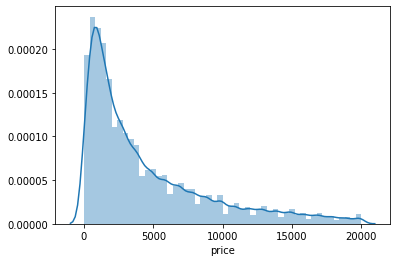

In [101]:
sns.distplot(cars.price)

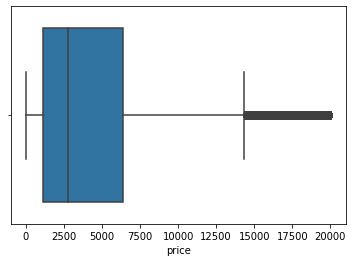

In [102]:
sns.boxplot(x=cars['price'])

In [103]:
cars['price'].describe()

count    340310.000000
mean       4431.180077
std        4489.703025
min           0.000000
25%        1100.000000
50%        2750.000000
75%        6400.000000
max       20000.000000
Name: price, dtype: float64

In [104]:
cars.query('price > 15000') 

,date_crawled,price,reg_year,power,km,reg_month,brand,date_created,last_seen,model_new,box,vehicle,fuel,no_repaired
1,2016-03-24 10:58:45,18300,2011,190.0,125000,5,audi,2016-03-24,2016-04-07 01:46:50,a4,manual,coupe,gasoline,yes
14,2016-03-21 12:57:01,17999,2011,190.0,70000,3,nissan,2016-03-21,2016-04-06 07:45:42,navara,manual,suv,gasoline,no
33,2016-03-25 21:48:47,18000,2007,218.0,20000,5,bmw,2016-03-25,2016-04-07 04:45:21,3er,auto,sedan,petrol,no
172,2016-03-07 12:38:19,19750,2006,305.0,50000,7,ford,2016-03-07,2016-03-12 20:18:29,mustang,manual,convertible,petrol,no
179,2016-03-08 20:58:31,16449,2015,110.0,10000,8,skoda,2016-03-08,2016-04-06 01:17:03,fabia,auto,wagon,petrol,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
351791,2016-04-04 15:54:07,15190,2011,140.0,80000,6,volkswagen,2016-04-04,2016-04-06 17:44:51,touran,manual,bus,petrol,no
351814,2016-03-25 19:38:19,17990,2007,174.0,125000,7,volkswagen,2016-03-25,2016-04-07 01:17:57,transporter,auto,bus,gasoline,no
351883,2016-03-11 11:59:21,16500,2013,116.0,30000,9,hyundai,2016-03-11,2016-04-07 06:16:09,i_reihe,manual,suv,gasoline,no
351910,2016-04-02 23:25:40,16999,2008,269.0,150000,7,audi,2016-04-02,2016-04-06 15:17:04,a6,auto,wagon,gasoline,no


In [105]:
cars.query('price < 500')

,date_crawled,price,reg_year,power,km,reg_month,brand,date_created,last_seen,model_new,box,vehicle,fuel,no_repaired
0,2016-03-24 11:52:17,480,1993,75.000000,150000,3,volkswagen,2016-03-24,2016-04-07 03:16:57,golf,manual,sedan,petrol,no
16,2016-04-01 12:46:46,300,2016,60.000000,150000,3,volkswagen,2016-04-01,2016-04-01 12:46:46,polo,manual,small,petrol,no
23,2016-03-12 19:43:07,450,1997,50.000000,150000,5,seat,2016-03-12,2016-03-21 01:46:11,arosa,manual,small,petrol,no
32,2016-03-15 20:59:01,245,1994,75.000000,150000,2,volkswagen,2016-03-15,2016-03-17 18:17:43,golf,manual,sedan,petrol,no
35,2016-03-08 07:54:46,350,2016,75.000000,150000,4,volkswagen,2016-03-08,2016-03-08 09:44:50,golf,manual,sedan,petrol,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
351922,2016-03-15 19:57:11,400,1991,129.174667,150000,5,subaru,2016-03-15,2016-03-19 15:49:00,legacy,manual,wagon,petrol,no
351933,2016-03-30 20:55:30,350,1996,65.000000,150000,3,fiat,2016-03-30,2016-04-07 13:50:41,punto,manual,small,petrol,no
351939,2016-04-04 14:41:28,390,1997,60.000000,100000,6,opel,2016-04-04,2016-04-06 15:46:11,corsa,auto,small,petrol,yes
351942,2016-03-31 19:52:33,180,1995,45.000000,125000,3,opel,2016-03-31,2016-04-06 14:18:04,corsa,manual,small,petrol,no


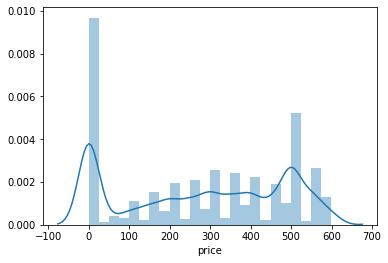

In [106]:
sns.distplot(cars.query('price < 600')['price'])

Поскольку стоимость - это наш целевой признак, поэтому менять его считаем нецелесообразным. Сделаем срез: пусть в нашем датафрейме останутся только те объекты, у которых стоимость больше 500 и меньше 15000 евро.

In [107]:
cars = cars.query('500 <= price <= 15000')
cars.shape

(294177, 14)

In [108]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 294177 entries, 2 to 351971
Data columns (total 14 columns):
date_crawled    294177 non-null datetime64[ns]
price           294177 non-null int64
reg_year        294177 non-null int64
power           294177 non-null float64
km              294177 non-null int64
reg_month       294177 non-null int64
brand           294177 non-null object
date_created    294177 non-null datetime64[ns]
last_seen       294177 non-null datetime64[ns]
model_new       294177 non-null object
box             294177 non-null object
vehicle         294177 non-null object
fuel            294177 non-null object
no_repaired     294177 non-null object
dtypes: datetime64[ns](3), float64(1), int64(4), object(6)
memory usage: 33.7+ MB


Нулевых значений больше нет. Можно обучать модели.

# 2. Обучение моделей

На шаге №2 мы будем обучать разные модели с различными гиперпараметрами. Для оценки качества моделей будем применять метрику RMSE.

Первой обучим линейную регрессию и посмотрим RMSE этой модели.  
Чтобы модель предсказывала эффективнее, проведем масштабирование признаков:

In [109]:
cars_ohe = pd.get_dummies(cars, drop_first=True)
target = cars_ohe['price']
features = cars_ohe.drop(['price', 'date_crawled', 'last_seen', 'date_created'], axis=1)

In [110]:
cars_ohe.head()

,date_crawled,price,reg_year,power,km,reg_month,date_created,last_seen,brand_audi,brand_bmw,...,vehicle_small,vehicle_suv,vehicle_wagon,fuel_electric,fuel_gasoline,fuel_hybrid,fuel_lpg,fuel_other,fuel_petrol,no_repaired_yes
2,2016-03-14 12:52:21,9800,2004,163.0,125000,8,2016-03-14,2016-04-05 12:47:46,0,0,...,0,1,0,0,1,0,0,0,0,0
3,2016-03-17 16:54:04,1500,2001,75.0,150000,6,2016-03-17,2016-03-17 17:40:17,0,0,...,1,0,0,0,0,0,0,0,1,0
4,2016-03-31 17:25:20,3600,2008,69.0,90000,7,2016-03-31,2016-04-06 10:17:21,0,0,...,1,0,0,0,1,0,0,0,0,0
5,2016-04-04 17:36:23,650,1995,102.0,150000,10,2016-04-04,2016-04-06 19:17:07,0,1,...,0,0,0,0,0,0,0,0,1,1
6,2016-04-01 20:48:51,2200,2004,109.0,150000,8,2016-04-01,2016-04-05 18:18:39,0,0,...,0,0,0,0,0,0,0,0,1,0


Поделим модифецированную выборку для линейной регрессии:

In [111]:
features_tn, features_val, target_tn, target_val = train_test_split(
    features, target, test_size=0.4, random_state=12345)
features_val, features_tt, target_val, target_tt = train_test_split(
    features, target, test_size=0.5, random_state=12345)

Проведем масштабироване признаков:

In [112]:
numeric = ['reg_year', 'power', 'km', 'reg_month']
numeric

['reg_year', 'power', 'km', 'reg_month']

In [113]:
scaler = StandardScaler()
scaler.fit(features_tn[numeric])
features_tn[numeric] = scaler.transform(features_tn[numeric])

features_val[numeric] = scaler.transform(features_val[numeric])

features_tt[numeric] = scaler.transform(features_tt[numeric])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

In [114]:
features_tn.head()

,reg_year,power,km,reg_month,brand_audi,brand_bmw,brand_chevrolet,brand_chrysler,brand_citroen,brand_dacia,...,vehicle_small,vehicle_suv,vehicle_wagon,fuel_electric,fuel_gasoline,fuel_hybrid,fuel_lpg,fuel_other,fuel_petrol,no_repaired_yes
321373,-1.427834,-0.969242,-1.160384,-0.689830,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
97579,-0.273737,0.421840,0.558055,-0.689830,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
33910,0.550618,0.442297,0.558055,-1.589804,1,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
20309,2.364198,-1.194270,-2.306010,-0.989822,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
42139,-1.757576,0.360468,0.558055,1.410108,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


С помощью GridSearchCV подберем параметры нашей модели:

In [115]:
datetime_begin = time.time()
model_reg = LinearRegression()
parameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
grid = GridSearchCV(model_reg,parameters, cv=None)
grid.fit(features_tn, target_tn)
print (grid.best_params_)
datetime_end = time.time()
print('Время расчета, сек : {:.2f}'.format(datetime_end - datetime_begin))

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'copy_X': True, 'fit_intercept': True, 'normalize': False}
Время расчета, сек : 289.22


Гиперпараметры подобрали, можем обучать:

In [116]:
datetime_begin = time.time()
model_reg = LinearRegression(copy_X=True, fit_intercept=True, normalize=False).fit(features_tn, target_tn)

datetime_end = time.time()
print('Время расчета, сек : {:.2f}'.format(datetime_end - datetime_begin))

Время расчета, сек : 16.99


Теперь посчитаем время предсказывания и RMSE:

In [117]:
datetime_begin = time.time()
predicted_val_reg = model_reg.predict(features_val)
print("Linear Regression")
print("RMSE:", mean_squared_error(target_val, predicted_val_reg) ** 0.5)
datetime_end = time.time()
print('Время расчета, сек : {:.2f}'.format(datetime_end - datetime_begin))

Linear Regression
RMSE: 2198.4518563399033
Время расчета, сек : 0.39


Проверим на тестовой выборке:

In [118]:
datetime_begin = time.time()
predicted_test = model_reg.predict(features_tt)
print("Linear Regression_test")
print("RMSE:", mean_squared_error(target_tt, predicted_test) ** 0.5)
datetime_end = time.time()
print('Время расчета, сек : {:.2f}'.format(datetime_end - datetime_begin))

Linear Regression_test
RMSE: 2212.9575788637644
Время расчета, сек : 0.30


Модель линейной регрессии учится быстро, предсказывает быстро, но RMSE высокий.  
Посмотрим на другие модели.  Поскольку для других моделей не обязательно проводить масштабирование и кодирование признаков, для них мы просто снова разделим выборку на 3 части:

In [119]:
features_train, features_valid, target_train, target_valid = train_test_split(
    cars.drop('price', axis=1), cars.price, test_size=0.4, random_state=12345)
features_valid, features_test, target_valid, target_test = train_test_split(
    cars.drop('price', axis=1), cars.price, test_size=0.5, random_state=12345)

print(features_train.shape)
print(target_train.shape)
print(features_valid.shape)
print(target_valid.shape)
print(features_test.shape)
print(target_test.shape)

(176506, 13)
(176506,)
(147088, 13)
(147088,)
(147089, 13)
(147089,)


Обучим модель ***CatBoost*** на наших данных, передав модели отдельно список категориальных переменных, чтобы их обработать:

In [120]:
cat_features = ['brand', 'model_new', 'box',
                'vehicle', 'fuel', 'no_repaired']

Сделаем словарь для перебора параметров:

In [121]:
params = {'depth':np.arange(5, 10),
          'iterations':[10, 50, 80, 100, 151],
          'learning_rate':np.arange(0.01, 0.1) 
          }

Выберем регрессионную модель, т.к. будем предсказывать количественные значения. А для функции потерь выберем метрику RMSE (квадратный корень из средней квадратичной ошибки):

In [122]:
model_cat = CatBoostRegressor(loss_function='RMSE', cat_features=cat_features)

Воспользуемся GridSearchCV для поиска оптимальных параметров:

In [123]:
datetime_begin = time.time()
grid_search_result = GridSearchCV(estimator=model_cat, param_grid = params, cv = 2, n_jobs=-1)
grid_search_result.fit(features_train, target_train)    


print("\n Results from Grid Search " )

print("\n The best parameters across ALL searched params:\n", grid_search_result.best_params_)

datetime_end = time.time()
print('Время расчета, сек : {:.2f}'.format(datetime_end - datetime_begin))

0:	learn: 3610.1020032	total: 70.9ms	remaining: 638ms
1:	learn: 3589.7472251	total: 265ms	remaining: 1.06s
2:	learn: 3568.2768912	total: 370ms	remaining: 863ms
3:	learn: 3547.4311350	total: 563ms	remaining: 845ms
4:	learn: 3526.8905558	total: 666ms	remaining: 666ms
5:	learn: 3506.9979861	total: 860ms	remaining: 573ms
6:	learn: 3486.9199954	total: 963ms	remaining: 413ms
7:	learn: 3467.1124058	total: 1.06s	remaining: 266ms
8:	learn: 3447.3206696	total: 1.26s	remaining: 140ms
9:	learn: 3428.6625803	total: 1.36s	remaining: 0us
0:	learn: 3594.4284899	total: 79.8ms	remaining: 718ms
1:	learn: 3574.1296269	total: 184ms	remaining: 735ms
2:	learn: 3554.2571447	total: 373ms	remaining: 871ms
3:	learn: 3533.6291449	total: 477ms	remaining: 716ms
4:	learn: 3513.9391085	total: 581ms	remaining: 581ms
5:	learn: 3493.9378675	total: 771ms	remaining: 514ms
6:	learn: 3473.2809544	total: 878ms	remaining: 376ms
7:	learn: 3454.0226235	total: 978ms	remaining: 244ms
8:	learn: 3434.1418807	total: 1.17s	remaining:

34:	learn: 3014.3549803	total: 4.76s	remaining: 6.12s
35:	learn: 3000.6999317	total: 4.87s	remaining: 5.95s
36:	learn: 2986.1912934	total: 4.97s	remaining: 5.78s
37:	learn: 2971.8899205	total: 5.16s	remaining: 5.7s
38:	learn: 2957.8875997	total: 5.27s	remaining: 5.54s
39:	learn: 2944.6571250	total: 5.46s	remaining: 5.46s
40:	learn: 2931.4214060	total: 5.57s	remaining: 5.3s
41:	learn: 2918.7919829	total: 5.76s	remaining: 5.21s
42:	learn: 2905.8109731	total: 5.96s	remaining: 5.13s
43:	learn: 2893.3113149	total: 6.06s	remaining: 4.96s
44:	learn: 2881.2841813	total: 6.26s	remaining: 4.87s
45:	learn: 2868.4563518	total: 6.37s	remaining: 4.71s
46:	learn: 2855.4599976	total: 6.56s	remaining: 4.6s
47:	learn: 2842.9178557	total: 6.66s	remaining: 4.44s
48:	learn: 2831.2002698	total: 6.85s	remaining: 4.34s
49:	learn: 2819.5035919	total: 6.96s	remaining: 4.17s
50:	learn: 2808.0615773	total: 7.16s	remaining: 4.07s
51:	learn: 2796.6026544	total: 7.26s	remaining: 3.91s
52:	learn: 2784.2376848	total: 

28:	learn: 3101.9922101	total: 3.84s	remaining: 9.39s
29:	learn: 3087.1282715	total: 3.94s	remaining: 9.19s
30:	learn: 3071.9806366	total: 4.04s	remaining: 9s
31:	learn: 3057.5859958	total: 4.23s	remaining: 9s
32:	learn: 3042.9117905	total: 4.34s	remaining: 8.81s
33:	learn: 3028.3864151	total: 4.44s	remaining: 8.62s
34:	learn: 3014.3549803	total: 4.63s	remaining: 8.6s
35:	learn: 3000.6999317	total: 4.74s	remaining: 8.42s
36:	learn: 2986.1912934	total: 4.84s	remaining: 8.24s
37:	learn: 2971.8899205	total: 5.03s	remaining: 8.21s
38:	learn: 2957.8875997	total: 5.13s	remaining: 8.03s
39:	learn: 2944.6571250	total: 5.23s	remaining: 7.85s
40:	learn: 2931.4214060	total: 5.43s	remaining: 7.81s
41:	learn: 2918.7919829	total: 5.53s	remaining: 7.64s
42:	learn: 2905.8109731	total: 5.63s	remaining: 7.47s
43:	learn: 2893.3113149	total: 5.74s	remaining: 7.31s
44:	learn: 2881.2841813	total: 5.93s	remaining: 7.25s
45:	learn: 2868.4563518	total: 6.03s	remaining: 7.08s
46:	learn: 2855.4599976	total: 6.22

82:	learn: 2486.0191136	total: 11.1s	remaining: 2.28s
83:	learn: 2477.6463794	total: 11.2s	remaining: 2.14s
84:	learn: 2470.1172697	total: 11.3s	remaining: 2s
85:	learn: 2462.5174599	total: 11.5s	remaining: 1.88s
86:	learn: 2454.2486714	total: 11.6s	remaining: 1.74s
87:	learn: 2446.1886651	total: 11.7s	remaining: 1.6s
88:	learn: 2438.5657115	total: 11.9s	remaining: 1.47s
89:	learn: 2431.4443380	total: 12s	remaining: 1.34s
90:	learn: 2424.2657319	total: 12.1s	remaining: 1.2s
91:	learn: 2416.6095541	total: 12.3s	remaining: 1.07s
92:	learn: 2408.8784435	total: 12.4s	remaining: 936ms
93:	learn: 2402.0460822	total: 12.5s	remaining: 800ms
94:	learn: 2395.3726133	total: 12.7s	remaining: 670ms
95:	learn: 2388.7491051	total: 12.8s	remaining: 535ms
96:	learn: 2381.5690027	total: 12.9s	remaining: 400ms
97:	learn: 2374.6679875	total: 13.1s	remaining: 268ms
98:	learn: 2367.9369442	total: 13.2s	remaining: 134ms
99:	learn: 2361.5252899	total: 13.3s	remaining: 0us
0:	learn: 3610.1020032	total: 23.9ms	

136:	learn: 2153.3114303	total: 17.7s	remaining: 1.81s
137:	learn: 2148.5584195	total: 17.8s	remaining: 1.68s
138:	learn: 2144.1738424	total: 17.9s	remaining: 1.55s
139:	learn: 2139.2906366	total: 18.1s	remaining: 1.42s
140:	learn: 2135.0519659	total: 18.2s	remaining: 1.29s
141:	learn: 2130.4836547	total: 18.3s	remaining: 1.16s
142:	learn: 2125.9229879	total: 18.5s	remaining: 1.03s
143:	learn: 2121.8602197	total: 18.6s	remaining: 905ms
144:	learn: 2117.5273204	total: 18.7s	remaining: 775ms
145:	learn: 2113.4772983	total: 18.9s	remaining: 648ms
146:	learn: 2109.4571395	total: 19s	remaining: 518ms
147:	learn: 2105.6083794	total: 19.1s	remaining: 388ms
148:	learn: 2101.4914011	total: 19.3s	remaining: 259ms
149:	learn: 2097.1841944	total: 19.4s	remaining: 129ms
150:	learn: 2092.9848436	total: 19.5s	remaining: 0us
0:	learn: 3594.4284899	total: 68.6ms	remaining: 10.3s
1:	learn: 3574.1296269	total: 263ms	remaining: 19.6s
2:	learn: 3554.2571447	total: 366ms	remaining: 18.1s
3:	learn: 3533.6291

138:	learn: 2139.3328470	total: 18.5s	remaining: 1.59s
139:	learn: 2134.5376263	total: 18.6s	remaining: 1.46s
140:	learn: 2129.6038480	total: 18.8s	remaining: 1.33s
141:	learn: 2125.4210858	total: 18.9s	remaining: 1.2s
142:	learn: 2121.2179724	total: 19s	remaining: 1.06s
143:	learn: 2117.2139548	total: 19.1s	remaining: 927ms
144:	learn: 2112.8074935	total: 19.3s	remaining: 797ms
145:	learn: 2108.7696622	total: 19.4s	remaining: 663ms
146:	learn: 2104.7596302	total: 19.5s	remaining: 530ms
147:	learn: 2100.8456258	total: 19.7s	remaining: 398ms
148:	learn: 2096.3401970	total: 19.8s	remaining: 265ms
149:	learn: 2092.5502735	total: 19.9s	remaining: 132ms
150:	learn: 2088.3081309	total: 20.1s	remaining: 0us
0:	learn: 3609.1082124	total: 97ms	remaining: 873ms
1:	learn: 3587.1536268	total: 293ms	remaining: 1.17s
2:	learn: 3564.3152057	total: 488ms	remaining: 1.14s
3:	learn: 3543.4093072	total: 594ms	remaining: 891ms
4:	learn: 3521.1433211	total: 788ms	remaining: 788ms
5:	learn: 3500.8876528	tot

22:	learn: 3173.5729208	total: 3.5s	remaining: 8.67s
23:	learn: 3156.4101471	total: 3.6s	remaining: 8.41s
24:	learn: 3138.9492948	total: 3.8s	remaining: 8.35s
25:	learn: 3121.5291071	total: 3.9s	remaining: 8.11s
26:	learn: 3106.0831352	total: 4.1s	remaining: 8.04s
27:	learn: 3089.4993906	total: 4.2s	remaining: 7.8s
28:	learn: 3073.6445229	total: 4.39s	remaining: 7.73s
29:	learn: 3057.4037701	total: 4.5s	remaining: 7.5s
30:	learn: 3041.8723945	total: 4.69s	remaining: 7.42s
31:	learn: 3027.1895593	total: 4.8s	remaining: 7.2s
32:	learn: 3012.5922705	total: 4.99s	remaining: 7.11s
33:	learn: 2997.6454626	total: 5.19s	remaining: 7.02s
34:	learn: 2982.5305324	total: 5.29s	remaining: 6.81s
35:	learn: 2967.1928007	total: 5.49s	remaining: 6.71s
36:	learn: 2952.0288730	total: 5.59s	remaining: 6.5s
37:	learn: 2937.4462499	total: 5.79s	remaining: 6.39s
38:	learn: 2923.1570497	total: 5.89s	remaining: 6.19s
39:	learn: 2908.8074258	total: 6.08s	remaining: 6.08s
40:	learn: 2895.4073176	total: 6.2s	rema

16:	learn: 3280.3506274	total: 2.58s	remaining: 12.6s
17:	learn: 3262.8393117	total: 2.77s	remaining: 12.6s
18:	learn: 3244.5078022	total: 2.88s	remaining: 12.3s
19:	learn: 3226.3663557	total: 3.07s	remaining: 12.3s
20:	learn: 3208.2903522	total: 3.17s	remaining: 11.9s
21:	learn: 3191.5178769	total: 3.37s	remaining: 11.9s
22:	learn: 3173.5729208	total: 3.48s	remaining: 11.6s
23:	learn: 3156.4101471	total: 3.67s	remaining: 11.6s
24:	learn: 3138.9492948	total: 3.77s	remaining: 11.3s
25:	learn: 3121.5291071	total: 3.96s	remaining: 11.3s
26:	learn: 3106.0831352	total: 4.07s	remaining: 11s
27:	learn: 3089.4993906	total: 4.26s	remaining: 11s
28:	learn: 3073.6445229	total: 4.37s	remaining: 10.7s
29:	learn: 3057.4037701	total: 4.56s	remaining: 10.6s
30:	learn: 3041.8723945	total: 4.67s	remaining: 10.4s
31:	learn: 3027.1895593	total: 4.86s	remaining: 10.3s
32:	learn: 3012.5922705	total: 4.96s	remaining: 10.1s
33:	learn: 2997.6454626	total: 5.16s	remaining: 10s
34:	learn: 2982.5305324	total: 5.2

70:	learn: 2540.5683933	total: 10.8s	remaining: 4.4s
71:	learn: 2531.0510763	total: 11s	remaining: 4.26s
72:	learn: 2521.7924644	total: 11.2s	remaining: 4.13s
73:	learn: 2512.1900225	total: 11.3s	remaining: 3.96s
74:	learn: 2502.7787652	total: 11.5s	remaining: 3.82s
75:	learn: 2493.4166050	total: 11.6s	remaining: 3.65s
76:	learn: 2484.4046586	total: 11.8s	remaining: 3.51s
77:	learn: 2475.7500821	total: 11.9s	remaining: 3.35s
78:	learn: 2467.4907842	total: 12.1s	remaining: 3.21s
79:	learn: 2459.2037627	total: 12.2s	remaining: 3.04s
80:	learn: 2450.1841531	total: 12.4s	remaining: 2.9s
81:	learn: 2441.9374759	total: 12.5s	remaining: 2.73s
82:	learn: 2433.9895944	total: 12.7s	remaining: 2.59s
83:	learn: 2426.1788594	total: 12.8s	remaining: 2.43s
84:	learn: 2417.6721926	total: 13s	remaining: 2.29s
85:	learn: 2409.5853657	total: 13.1s	remaining: 2.13s
86:	learn: 2401.3394482	total: 13.3s	remaining: 1.98s
87:	learn: 2393.2033204	total: 13.4s	remaining: 1.82s
88:	learn: 2385.1885360	total: 13.

124:	learn: 2148.4341350	total: 19.1s	remaining: 3.98s
125:	learn: 2143.2304270	total: 19.2s	remaining: 3.81s
126:	learn: 2137.8411935	total: 19.4s	remaining: 3.67s
127:	learn: 2132.5273306	total: 19.5s	remaining: 3.51s
128:	learn: 2127.4109441	total: 19.7s	remaining: 3.36s
129:	learn: 2122.3390346	total: 19.8s	remaining: 3.2s
130:	learn: 2117.1101182	total: 20s	remaining: 3.06s
131:	learn: 2112.3827033	total: 20.1s	remaining: 2.9s
132:	learn: 2107.3835228	total: 20.3s	remaining: 2.75s
133:	learn: 2102.2545936	total: 20.4s	remaining: 2.59s
134:	learn: 2097.4260647	total: 20.6s	remaining: 2.44s
135:	learn: 2092.5188078	total: 20.8s	remaining: 2.29s
136:	learn: 2087.6596591	total: 21s	remaining: 2.15s
137:	learn: 2082.7002278	total: 21.1s	remaining: 1.99s
138:	learn: 2077.7761354	total: 21.3s	remaining: 1.84s
139:	learn: 2073.1739355	total: 21.4s	remaining: 1.68s
140:	learn: 2068.6653130	total: 21.6s	remaining: 1.53s
141:	learn: 2064.2369076	total: 21.7s	remaining: 1.38s
142:	learn: 2059

126:	learn: 2133.3753059	total: 19.4s	remaining: 3.67s
127:	learn: 2128.0551857	total: 19.5s	remaining: 3.51s
128:	learn: 2122.8489642	total: 19.7s	remaining: 3.36s
129:	learn: 2117.5340593	total: 19.8s	remaining: 3.2s
130:	learn: 2112.4130054	total: 20s	remaining: 3.06s
131:	learn: 2107.4067669	total: 20.1s	remaining: 2.9s
132:	learn: 2102.3276219	total: 20.3s	remaining: 2.75s
133:	learn: 2097.1638574	total: 20.4s	remaining: 2.59s
134:	learn: 2092.1534837	total: 20.6s	remaining: 2.44s
135:	learn: 2087.1833049	total: 20.7s	remaining: 2.29s
136:	learn: 2082.1656037	total: 20.9s	remaining: 2.14s
137:	learn: 2077.1147612	total: 21s	remaining: 1.98s
138:	learn: 2072.4032149	total: 21.2s	remaining: 1.83s
139:	learn: 2068.0853833	total: 21.3s	remaining: 1.67s
140:	learn: 2063.3172057	total: 21.5s	remaining: 1.52s
141:	learn: 2058.7631495	total: 21.6s	remaining: 1.37s
142:	learn: 2054.3431632	total: 21.8s	remaining: 1.22s
143:	learn: 2049.9946947	total: 21.9s	remaining: 1.06s
144:	learn: 2045

8:	learn: 3431.3761251	total: 1.57s	remaining: 12.4s
9:	learn: 3410.2378417	total: 1.68s	remaining: 11.7s
10:	learn: 3390.4147027	total: 1.88s	remaining: 11.8s
11:	learn: 3369.9794620	total: 2.07s	remaining: 11.7s
12:	learn: 3350.0222825	total: 2.27s	remaining: 11.7s
13:	learn: 3330.1330037	total: 2.46s	remaining: 11.6s
14:	learn: 3310.2215140	total: 2.57s	remaining: 11.2s
15:	learn: 3290.2429175	total: 2.77s	remaining: 11.1s
16:	learn: 3270.5036857	total: 2.97s	remaining: 11s
17:	learn: 3250.6502622	total: 3.16s	remaining: 10.9s
18:	learn: 3231.6433063	total: 3.36s	remaining: 10.8s
19:	learn: 3212.2252986	total: 3.56s	remaining: 10.7s
20:	learn: 3194.4207755	total: 3.67s	remaining: 10.3s
21:	learn: 3175.8541361	total: 3.86s	remaining: 10.2s
22:	learn: 3157.6492977	total: 4.06s	remaining: 10.1s
23:	learn: 3139.2544204	total: 4.25s	remaining: 9.93s
24:	learn: 3121.6068868	total: 4.45s	remaining: 9.8s
25:	learn: 3104.1398464	total: 4.56s	remaining: 9.47s
26:	learn: 3086.5691997	total: 4.

2:	learn: 3561.7189823	total: 464ms	remaining: 15s
3:	learn: 3539.0859587	total: 664ms	remaining: 15.9s
4:	learn: 3516.9925634	total: 773ms	remaining: 14.7s
5:	learn: 3496.2303652	total: 966ms	remaining: 15.1s
6:	learn: 3474.5337844	total: 1.16s	remaining: 15.4s
7:	learn: 3452.8124958	total: 1.27s	remaining: 14.6s
8:	learn: 3431.3761251	total: 1.46s	remaining: 14.8s
9:	learn: 3410.2378417	total: 1.66s	remaining: 14.9s
10:	learn: 3390.4147027	total: 1.86s	remaining: 15s
11:	learn: 3369.9794620	total: 1.96s	remaining: 14.4s
12:	learn: 3350.0222825	total: 2.16s	remaining: 14.4s
13:	learn: 3330.1330037	total: 2.35s	remaining: 14.5s
14:	learn: 3310.2215140	total: 2.55s	remaining: 14.5s
15:	learn: 3290.2429175	total: 2.67s	remaining: 14s
16:	learn: 3270.5036857	total: 2.86s	remaining: 14s
17:	learn: 3250.6502622	total: 3.06s	remaining: 13.9s
18:	learn: 3231.6433063	total: 3.25s	remaining: 13.9s
19:	learn: 3212.2252986	total: 3.45s	remaining: 13.8s
20:	learn: 3194.4207755	total: 3.57s	remaini

57:	learn: 2640.5414583	total: 10.5s	remaining: 7.58s
58:	learn: 2629.4287352	total: 10.6s	remaining: 7.35s
59:	learn: 2618.2094166	total: 10.8s	remaining: 7.18s
60:	learn: 2606.9368090	total: 11s	remaining: 7.01s
61:	learn: 2595.9265167	total: 11.1s	remaining: 6.79s
62:	learn: 2585.2506630	total: 11.3s	remaining: 6.62s
63:	learn: 2574.9130877	total: 11.5s	remaining: 6.45s
64:	learn: 2564.0728898	total: 11.7s	remaining: 6.28s
65:	learn: 2553.7545194	total: 11.9s	remaining: 6.11s
66:	learn: 2543.5102635	total: 12.1s	remaining: 5.94s
67:	learn: 2532.7520460	total: 12.3s	remaining: 5.77s
68:	learn: 2522.6336863	total: 12.4s	remaining: 5.56s
69:	learn: 2512.4045927	total: 12.6s	remaining: 5.39s
70:	learn: 2502.7114815	total: 12.8s	remaining: 5.21s
71:	learn: 2493.1449879	total: 13s	remaining: 5.04s
72:	learn: 2483.4319588	total: 13.1s	remaining: 4.83s
73:	learn: 2473.3825603	total: 13.3s	remaining: 4.66s
74:	learn: 2463.6400345	total: 13.5s	remaining: 4.49s
75:	learn: 2454.4112451	total: 1

110:	learn: 2182.0942647	total: 19.6s	remaining: 7.05s
111:	learn: 2175.5730454	total: 19.8s	remaining: 6.88s
112:	learn: 2169.3754506	total: 19.9s	remaining: 6.68s
113:	learn: 2163.0969849	total: 20.1s	remaining: 6.51s
114:	learn: 2156.6035601	total: 20.3s	remaining: 6.34s
115:	learn: 2150.4594751	total: 20.5s	remaining: 6.17s
116:	learn: 2144.2475023	total: 20.7s	remaining: 6s
117:	learn: 2138.1294282	total: 20.8s	remaining: 5.81s
118:	learn: 2132.1301215	total: 21s	remaining: 5.64s
119:	learn: 2126.3012758	total: 21.2s	remaining: 5.46s
120:	learn: 2120.2495737	total: 21.4s	remaining: 5.29s
121:	learn: 2114.6294614	total: 21.5s	remaining: 5.1s
122:	learn: 2109.1086768	total: 21.7s	remaining: 4.93s
123:	learn: 2103.3813341	total: 21.8s	remaining: 4.76s
124:	learn: 2097.9391292	total: 22s	remaining: 4.57s
125:	learn: 2092.4318306	total: 22.1s	remaining: 4.39s
126:	learn: 2087.0386811	total: 22.3s	remaining: 4.22s
127:	learn: 2081.7524106	total: 22.5s	remaining: 4.03s
128:	learn: 2076.4

112:	learn: 2167.0229415	total: 20s	remaining: 6.71s
113:	learn: 2160.5612126	total: 20.1s	remaining: 6.52s
114:	learn: 2154.2407803	total: 20.3s	remaining: 6.35s
115:	learn: 2148.0131122	total: 20.5s	remaining: 6.17s
116:	learn: 2141.8537996	total: 20.6s	remaining: 5.98s
117:	learn: 2135.4765002	total: 20.8s	remaining: 5.81s
118:	learn: 2129.5323929	total: 21s	remaining: 5.64s
119:	learn: 2123.4375104	total: 21.2s	remaining: 5.47s
120:	learn: 2117.7575160	total: 21.3s	remaining: 5.27s
121:	learn: 2111.7210484	total: 21.5s	remaining: 5.1s
122:	learn: 2106.0347391	total: 21.7s	remaining: 4.93s
123:	learn: 2099.9991167	total: 21.9s	remaining: 4.76s
124:	learn: 2094.4149492	total: 22s	remaining: 4.57s
125:	learn: 2088.8417251	total: 22.2s	remaining: 4.4s
126:	learn: 2083.1418386	total: 22.4s	remaining: 4.22s
127:	learn: 2077.7825407	total: 22.6s	remaining: 4.05s
128:	learn: 2072.3427917	total: 22.8s	remaining: 3.88s
129:	learn: 2067.1048920	total: 22.9s	remaining: 3.69s
130:	learn: 2061.9

44:	learn: 2778.3054231	total: 9.04s	remaining: 1s
45:	learn: 2764.2823740	total: 9.24s	remaining: 804ms
46:	learn: 2750.5205229	total: 9.44s	remaining: 603ms
47:	learn: 2737.4496706	total: 9.64s	remaining: 402ms
48:	learn: 2724.1596846	total: 9.84s	remaining: 201ms
49:	learn: 2711.0832074	total: 10s	remaining: 0us
0:	learn: 3607.0204938	total: 177ms	remaining: 14s
1:	learn: 3583.5332294	total: 375ms	remaining: 14.6s
2:	learn: 3559.9676169	total: 575ms	remaining: 14.7s
3:	learn: 3536.5080313	total: 777ms	remaining: 14.8s
4:	learn: 3513.5833222	total: 976ms	remaining: 14.6s
5:	learn: 3490.9396722	total: 1.18s	remaining: 14.5s
6:	learn: 3468.8009010	total: 1.38s	remaining: 14.4s
7:	learn: 3446.4174794	total: 1.67s	remaining: 15.1s
8:	learn: 3424.2987527	total: 1.87s	remaining: 14.8s
9:	learn: 3402.3045593	total: 2.07s	remaining: 14.5s
10:	learn: 3380.9941642	total: 2.27s	remaining: 14.2s
11:	learn: 3359.5395278	total: 2.47s	remaining: 14s
12:	learn: 3338.6574815	total: 2.67s	remaining: 1

67:	learn: 2500.7370427	total: 13.6s	remaining: 2.39s
68:	learn: 2490.4261702	total: 13.8s	remaining: 2.19s
69:	learn: 2479.8511298	total: 14s	remaining: 1.99s
70:	learn: 2469.6996949	total: 14.2s	remaining: 1.79s
71:	learn: 2459.3118831	total: 14.4s	remaining: 1.59s
72:	learn: 2449.6541120	total: 14.6s	remaining: 1.4s
73:	learn: 2440.4145503	total: 14.8s	remaining: 1.2s
74:	learn: 2430.6832496	total: 15s	remaining: 997ms
75:	learn: 2421.4583071	total: 15.2s	remaining: 798ms
76:	learn: 2412.3748756	total: 15.4s	remaining: 598ms
77:	learn: 2402.8759655	total: 15.6s	remaining: 399ms
78:	learn: 2393.5387067	total: 15.8s	remaining: 199ms
79:	learn: 2384.3125469	total: 16s	remaining: 0us
0:	learn: 3607.0204938	total: 182ms	remaining: 18s
1:	learn: 3583.5332294	total: 383ms	remaining: 18.8s
2:	learn: 3559.9676169	total: 587ms	remaining: 19s
3:	learn: 3536.5080313	total: 787ms	remaining: 18.9s
4:	learn: 3513.5833222	total: 986ms	remaining: 18.7s
5:	learn: 3490.9396722	total: 1.18s	remaining: 

40:	learn: 2835.6761782	total: 8.35s	remaining: 12s
41:	learn: 2821.0670443	total: 8.55s	remaining: 11.8s
42:	learn: 2806.5163415	total: 8.75s	remaining: 11.6s
43:	learn: 2792.3078103	total: 8.95s	remaining: 11.4s
44:	learn: 2778.3054231	total: 9.14s	remaining: 11.2s
45:	learn: 2764.2823740	total: 9.35s	remaining: 11s
46:	learn: 2750.5205229	total: 9.55s	remaining: 10.8s
47:	learn: 2737.4496706	total: 9.75s	remaining: 10.6s
48:	learn: 2724.1596846	total: 9.94s	remaining: 10.3s
49:	learn: 2711.0832074	total: 10.1s	remaining: 10.1s
50:	learn: 2698.3400344	total: 10.3s	remaining: 9.94s
51:	learn: 2685.1520845	total: 10.5s	remaining: 9.73s
52:	learn: 2672.5677144	total: 10.7s	remaining: 9.52s
53:	learn: 2660.1506926	total: 10.9s	remaining: 9.31s
54:	learn: 2647.2554195	total: 11.1s	remaining: 9.11s
55:	learn: 2634.9926632	total: 11.3s	remaining: 8.91s
56:	learn: 2622.8748233	total: 11.5s	remaining: 8.7s
57:	learn: 2611.3331598	total: 11.7s	remaining: 8.5s
58:	learn: 2599.3527441	total: 11.

93:	learn: 2275.1842734	total: 19.3s	remaining: 11.7s
94:	learn: 2266.8090567	total: 19.5s	remaining: 11.5s
95:	learn: 2258.6808667	total: 19.7s	remaining: 11.3s
96:	learn: 2250.3089012	total: 19.9s	remaining: 11.1s
97:	learn: 2242.4223808	total: 20.1s	remaining: 10.9s
98:	learn: 2234.3613599	total: 20.3s	remaining: 10.7s
99:	learn: 2226.8244974	total: 20.5s	remaining: 10.5s
100:	learn: 2219.4860789	total: 20.7s	remaining: 10.2s
101:	learn: 2211.9389673	total: 20.9s	remaining: 10s
102:	learn: 2204.4958719	total: 21.1s	remaining: 9.83s
103:	learn: 2196.8366988	total: 21.3s	remaining: 9.62s
104:	learn: 2189.5085591	total: 21.5s	remaining: 9.41s
105:	learn: 2182.2417002	total: 21.7s	remaining: 9.21s
106:	learn: 2174.9828960	total: 21.9s	remaining: 9s
107:	learn: 2168.3785806	total: 22.1s	remaining: 8.79s
108:	learn: 2161.5295124	total: 22.3s	remaining: 8.59s
109:	learn: 2154.7080079	total: 22.5s	remaining: 8.38s
110:	learn: 2148.1086698	total: 22.7s	remaining: 8.17s
111:	learn: 2141.21936

95:	learn: 2251.8447986	total: 19.1s	remaining: 11s
96:	learn: 2243.6611738	total: 19.4s	remaining: 10.8s
97:	learn: 2235.5481624	total: 19.5s	remaining: 10.6s
98:	learn: 2227.5655986	total: 19.7s	remaining: 10.4s
99:	learn: 2219.5862880	total: 19.9s	remaining: 10.2s
100:	learn: 2211.7070990	total: 20.1s	remaining: 9.97s
101:	learn: 2204.0509216	total: 20.3s	remaining: 9.77s
102:	learn: 2196.6582580	total: 20.5s	remaining: 9.57s
103:	learn: 2189.0986167	total: 20.7s	remaining: 9.37s
104:	learn: 2181.6700452	total: 20.9s	remaining: 9.18s
105:	learn: 2174.1703215	total: 21.1s	remaining: 8.97s
106:	learn: 2167.0170843	total: 21.3s	remaining: 8.78s
107:	learn: 2159.8073350	total: 21.5s	remaining: 8.57s
108:	learn: 2152.7609413	total: 21.7s	remaining: 8.38s
109:	learn: 2145.8496283	total: 21.9s	remaining: 8.18s
110:	learn: 2139.3170877	total: 22.1s	remaining: 7.98s
111:	learn: 2132.4789646	total: 22.3s	remaining: 7.78s
112:	learn: 2125.9151554	total: 22.5s	remaining: 7.58s
113:	learn: 2119.

26:	learn: 3049.7421406	total: 6.26s	remaining: 5.33s
27:	learn: 3032.1556189	total: 6.46s	remaining: 5.08s
28:	learn: 3015.7627554	total: 6.67s	remaining: 4.83s
29:	learn: 2997.9877668	total: 6.96s	remaining: 4.64s
30:	learn: 2980.5818962	total: 7.16s	remaining: 4.39s
31:	learn: 2963.4621198	total: 7.36s	remaining: 4.14s
32:	learn: 2946.6652694	total: 7.65s	remaining: 3.94s
33:	learn: 2930.2336800	total: 7.86s	remaining: 3.7s
34:	learn: 2914.1506905	total: 8.15s	remaining: 3.49s
35:	learn: 2898.2182082	total: 8.35s	remaining: 3.25s
36:	learn: 2882.1611145	total: 8.55s	remaining: 3s
37:	learn: 2866.1679361	total: 8.76s	remaining: 2.77s
38:	learn: 2850.1291206	total: 9.05s	remaining: 2.55s
39:	learn: 2834.7426872	total: 9.26s	remaining: 2.31s
40:	learn: 2819.3774544	total: 9.55s	remaining: 2.1s
41:	learn: 2804.4254929	total: 9.75s	remaining: 1.86s
42:	learn: 2790.2447785	total: 10s	remaining: 1.64s
43:	learn: 2775.9543515	total: 10.3s	remaining: 1.4s
44:	learn: 2761.8218187	total: 10.5s

50:	learn: 2679.7816107	total: 12s	remaining: 6.8s
51:	learn: 2666.8222802	total: 12.3s	remaining: 6.6s
52:	learn: 2653.6642124	total: 12.5s	remaining: 6.34s
53:	learn: 2640.6942451	total: 12.7s	remaining: 6.09s
54:	learn: 2627.8057457	total: 12.9s	remaining: 5.88s
55:	learn: 2615.3211215	total: 13.2s	remaining: 5.64s
56:	learn: 2603.1956200	total: 13.4s	remaining: 5.42s
57:	learn: 2590.8306078	total: 13.6s	remaining: 5.18s
58:	learn: 2578.6006010	total: 13.9s	remaining: 4.93s
59:	learn: 2566.4706907	total: 14.1s	remaining: 4.71s
60:	learn: 2554.9493921	total: 14.3s	remaining: 4.47s
61:	learn: 2542.9882074	total: 14.6s	remaining: 4.25s
62:	learn: 2531.5900559	total: 14.8s	remaining: 4.01s
63:	learn: 2520.5119530	total: 15.1s	remaining: 3.79s
64:	learn: 2509.2887295	total: 15.3s	remaining: 3.54s
65:	learn: 2498.3664225	total: 15.5s	remaining: 3.3s
66:	learn: 2487.4731631	total: 15.8s	remaining: 3.07s
67:	learn: 2476.9501770	total: 16s	remaining: 2.83s
68:	learn: 2466.3116323	total: 16.2

24:	learn: 3085.2819570	total: 5.77s	remaining: 17.3s
25:	learn: 3067.1493071	total: 6.06s	remaining: 17.3s
26:	learn: 3049.7421406	total: 6.26s	remaining: 16.9s
27:	learn: 3032.1556189	total: 6.47s	remaining: 16.6s
28:	learn: 3015.7627554	total: 6.76s	remaining: 16.5s
29:	learn: 2997.9877668	total: 6.96s	remaining: 16.2s
30:	learn: 2980.5818962	total: 7.16s	remaining: 15.9s
31:	learn: 2963.4621198	total: 7.45s	remaining: 15.8s
32:	learn: 2946.6652694	total: 7.65s	remaining: 15.5s
33:	learn: 2930.2336800	total: 7.86s	remaining: 15.3s
34:	learn: 2914.1506905	total: 8.15s	remaining: 15.1s
35:	learn: 2898.2182082	total: 8.35s	remaining: 14.8s
36:	learn: 2882.1611145	total: 8.55s	remaining: 14.6s
37:	learn: 2866.1679361	total: 8.76s	remaining: 14.3s
38:	learn: 2850.1291206	total: 9.05s	remaining: 14.1s
39:	learn: 2834.7426872	total: 9.25s	remaining: 13.9s
40:	learn: 2819.3774544	total: 9.45s	remaining: 13.6s
41:	learn: 2804.4254929	total: 9.74s	remaining: 13.5s
42:	learn: 2790.2447785	tota

77:	learn: 2385.3185390	total: 18.6s	remaining: 17.4s
78:	learn: 2375.8633522	total: 18.8s	remaining: 17.1s
79:	learn: 2366.5827601	total: 19s	remaining: 16.9s
80:	learn: 2357.6484446	total: 19.3s	remaining: 16.7s
81:	learn: 2348.9661029	total: 19.5s	remaining: 16.4s
82:	learn: 2340.1916725	total: 19.8s	remaining: 16.2s
83:	learn: 2331.2778370	total: 20s	remaining: 15.9s
84:	learn: 2322.6967356	total: 20.2s	remaining: 15.7s
85:	learn: 2314.1543612	total: 20.5s	remaining: 15.5s
86:	learn: 2306.0043029	total: 20.7s	remaining: 15.2s
87:	learn: 2297.5776468	total: 21s	remaining: 15s
88:	learn: 2289.4260126	total: 21.2s	remaining: 14.7s
89:	learn: 2281.4249350	total: 21.4s	remaining: 14.5s
90:	learn: 2273.4032138	total: 21.6s	remaining: 14.2s
91:	learn: 2264.4240796	total: 21.9s	remaining: 14s
92:	learn: 2255.8305531	total: 22.1s	remaining: 13.8s
93:	learn: 2247.0512127	total: 22.3s	remaining: 13.5s
94:	learn: 2238.5862788	total: 22.6s	remaining: 13.3s
95:	learn: 2230.1692233	total: 22.8s	r

79:	learn: 2358.4924337	total: 18.8s	remaining: 16.7s
80:	learn: 2349.5252112	total: 19.1s	remaining: 16.5s
81:	learn: 2340.6651153	total: 19.3s	remaining: 16.2s
82:	learn: 2332.0085357	total: 19.5s	remaining: 16s
83:	learn: 2323.5771722	total: 19.8s	remaining: 15.8s
84:	learn: 2315.0997432	total: 20s	remaining: 15.5s
85:	learn: 2306.7010445	total: 20.2s	remaining: 15.2s
86:	learn: 2298.3764601	total: 20.5s	remaining: 15.1s
87:	learn: 2290.1866254	total: 20.7s	remaining: 14.8s
88:	learn: 2282.2441907	total: 20.9s	remaining: 14.5s
89:	learn: 2274.4617758	total: 21.2s	remaining: 14.3s
90:	learn: 2266.8886027	total: 21.4s	remaining: 14.1s
91:	learn: 2258.2395082	total: 21.7s	remaining: 13.9s
92:	learn: 2249.2056667	total: 21.9s	remaining: 13.6s
93:	learn: 2240.5406022	total: 22.1s	remaining: 13.4s
94:	learn: 2231.8754504	total: 22.4s	remaining: 13.2s
95:	learn: 2223.2998802	total: 22.6s	remaining: 12.9s
96:	learn: 2215.0502849	total: 22.9s	remaining: 12.7s
97:	learn: 2206.8485007	total: 2

81:	learn: 2339.3404010	total: 30.9s	remaining: 26s
82:	learn: 2330.5179596	total: 31.3s	remaining: 25.6s
83:	learn: 2321.9331193	total: 31.6s	remaining: 25.2s
84:	learn: 2313.7426999	total: 32s	remaining: 24.8s
85:	learn: 2305.4537517	total: 32.3s	remaining: 24.4s
86:	learn: 2297.3355291	total: 32.7s	remaining: 24.1s
87:	learn: 2289.2196883	total: 33.1s	remaining: 23.7s
88:	learn: 2281.2834765	total: 33.4s	remaining: 23.3s
89:	learn: 2273.3609535	total: 33.8s	remaining: 22.9s
90:	learn: 2265.4911262	total: 34.1s	remaining: 22.5s
91:	learn: 2257.6592144	total: 34.5s	remaining: 22.2s
92:	learn: 2249.9989111	total: 34.9s	remaining: 21.8s
93:	learn: 2241.5493959	total: 35.3s	remaining: 21.4s
94:	learn: 2232.8745772	total: 35.7s	remaining: 21.1s
95:	learn: 2224.2018546	total: 36s	remaining: 20.6s
96:	learn: 2215.8099156	total: 36.4s	remaining: 20.3s
97:	learn: 2207.5548957	total: 36.7s	remaining: 19.9s
98:	learn: 2199.3474340	total: 37.1s	remaining: 19.5s
99:	learn: 2191.6738733	total: 37.

Обучим модель с наилучшими параметрами:

In [124]:
model_cat = CatBoostRegressor(loss_function='RMSE', cat_features=cat_features, 
                              iterations=151, learning_rate=0.01, depth=9)

In [125]:
datetime_begin = time.time()
model_cat.fit(features_train, target_train, cat_features=cat_features, verbose=50)
datetime_end = time.time()
print('Время расчета, сек : {:.2f}'.format(datetime_end - datetime_begin))

0:	learn: 3598.7206127	total: 340ms	remaining: 51s
50:	learn: 2677.1279965	total: 19.5s	remaining: 38.2s
100:	learn: 2183.6833642	total: 38s	remaining: 18.8s
150:	learn: 1899.1498805	total: 56.1s	remaining: 0us
Время расчета, сек : 63.13


Предскажем стоимость и посчитаем RMSE:

In [126]:
datetime_begin = time.time()
predicted_valid = model_cat.predict(features_valid)
mse = mean_squared_error(target_valid, predicted_valid)

datetime_end = time.time()
print('Время расчета, сек : {:.2f}'.format(datetime_end - datetime_begin))
print()
print("CatBoostRegressor")
print("RMSE =", mse ** 0.5)

Время расчета, сек : 0.79

CatBoostRegressor
RMSE = 1897.7648361681893


Проверим работу модели на тестовой выборке:

In [127]:
datetime_begin = time.time()
predicted_test = model_cat.predict(features_test)
mse = mean_squared_error(target_test, predicted_test)

datetime_end = time.time()
print('Время расчета, сек : {:.2f}'.format(datetime_end - datetime_begin))
print()
print("CatBoostRegressor_test")
print("RMSE =", mse ** 0.5)

Время расчета, сек : 0.90

CatBoostRegressor_test
RMSE = 1901.423728428878


Таким образом, мы увидели, что скорость обучения составляет порядка минуты. Скорость предсказания в среднем до 1 секунды. Метрика качества - корень из среднеквадратичной ошибки - на тестовой выборке составляет порядка 1901,42. Меньше, чем у линейной регрессии, однако и время обучения гораздо дольше.

Теперь обучим моделью ***LightGBM***:

Преобразуем данные обучения в формат набора данных LightGBM:

In [128]:
for col in ['brand', 'model_new', 'box', 'vehicle', 
            'fuel', 'no_repaired']:
    features_train[col] = features_train[col].astype('category')
    features_valid[col] = features_valid[col].astype('category')
    features_test[col] = features_test[col].astype('category')

In [129]:
features_train = features_train.drop(['date_crawled', 'date_created', 'last_seen'], axis=1)
features_valid = features_valid.drop(['date_crawled', 'date_created', 'last_seen'], axis=1)
features_test = features_test.drop(['date_crawled', 'date_created', 'last_seen'], axis=1)

In [130]:
train_data = lgb.Dataset(features_train, label=target_train, categorical_feature=cat_features)
valid_data = lgb.Dataset(features_valid, label=target_valid)
test_data = lgb.Dataset(features_test, label=target_test)

Для функции потерь выберем MSE:

In [131]:
score_func = make_scorer(mean_squared_error, greater_is_better=False)

Словарь с параметрами и их значениями будем использовать тот же, что и для CatBoost.

Подберем оптимальные параметры:

In [132]:
datetime_begin = time.time()

lgb_estimator = lgb.LGBMRegressor(boosting_type='gbdt', metric='RMSE')

gsearch = GridSearchCV(lgb_estimator, param_grid=params, scoring=score_func, cv = 2, n_jobs=-1)
lgb_model = gsearch.fit(X=features_train, y=target_train)


print("\n Results from Grid Search " )

print("\n The best parameters across ALL searched params:\n", lgb_model.best_params_)


datetime_end = time.time()
print('Время расчета, сек : {:.2f}'.format(datetime_end - datetime_begin))


 Results from Grid Search 

 The best parameters across ALL searched params:
 {'depth': 5, 'iterations': 10, 'learning_rate': 0.01}
Время расчета, сек : 305.58


Обучим модель:

In [136]:
datetime_begin = time.time()
model_lgb = lgb.LGBMRegressor(boosting_type='gbdt', metric='RMSE', max_depth=5, learning_rate=0.01, iterations=10)
model_lgb.fit(features_train, target_train)

datetime_end = time.time()
print('Время расчета, сек : {:.2f}'.format(datetime_end - datetime_begin))

Время расчета, сек : 6.79


Посчитаем время предсказания и RMSE:

In [137]:
datetime_begin = time.time()

predict_lgb = model_lgb.predict(features_valid)

print("LightGBM")
print("RMSE =", mean_squared_error(target_valid, predict_lgb) ** 0.5)
print()
datetime_end = time.time()
print('Время расчета, сек : {:.2f}'.format(datetime_end - datetime_begin))

LightGBM
RMSE = 2147.7047858502656

Время расчета, сек : 1.35


И проверим на тестовой выборке:

In [138]:
datetime_begin = time.time()

predict_lgb_test = model_lgb.predict(features_test)

print("LightGBM_test")
print("RMSE =", mean_squared_error(target_test, predict_lgb_test) ** 0.5)
print()
datetime_end = time.time()
print('Время расчета, сек : {:.2f}'.format(datetime_end - datetime_begin))

LightGBM_test
RMSE = 2147.431124440319

Время расчета, сек : 1.41


Так же, как и при обучении модели CatBoost, мы перебрали несколько гиперпараметров. 
RMSE при оценке качества модели LightGBM несколько выше, чем у модели CatBoost, однако и скорость обучения также выше.